In [37]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


In [19]:

IMG_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10


In [20]:

# path to your dataset directory
dataset_dir = 'c:\\Users\\Asus\\Desktop\\DL-PotatoDisease\\training\\Potato'

# Print the absolute path to verify it
print(f"Dataset directory: {dataset_dir}")

# Check if the directory exists
if os.path.exists(dataset_dir):
    # List the contents of the dataset directory to verify the structure
    print(f"Contents of the dataset directory: {os.listdir(dataset_dir)}")
else:
    print(f"Directory does not exist: {dataset_dir}")


Dataset directory: c:\Users\Asus\Desktop\DL-PotatoDisease\training\Potato
Contents of the dataset directory: ['Early', 'Healthy', 'Late']


In [21]:

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Print class names to verify
print(f"Class names: {dataset.class_names}")

Found 2383 files belonging to 3 classes.
Class names: ['Early', 'Healthy', 'Late']


In [22]:
#Get Classes
class_names=dataset.class_names
class_names

['Early', 'Healthy', 'Late']

In [23]:
#Get length
len(dataset)

75

In [24]:
#get dimension of first image
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


In [25]:
# Debug: Print out all file paths and their corresponding labels
print("Checking all file paths and labels:")
for image_batch, label_batch in dataset:
    for img, lbl in zip(image_batch, label_batch):
        img_idx = int(lbl)
        class_name = dataset.class_names[img_idx]
        print(f"File path: {dataset.file_paths[img_idx]},Label: {img_idx}, Class name: {class_name}")

Checking all file paths and labels:
File path: c:\Users\Asus\Desktop\DL-PotatoDisease\training\Potato\Early\8ff3274d-02b2-4859-9415-982aa4ec7d8c___RS_Early.B 7465.JPG,Label: 0, Class name: Early
File path: c:\Users\Asus\Desktop\DL-PotatoDisease\training\Potato\Early\8ff3274d-02b2-4859-9415-982aa4ec7d8c___RS_Early.B 7465.JPG,Label: 0, Class name: Early
File path: c:\Users\Asus\Desktop\DL-PotatoDisease\training\Potato\Late\31d61797-f3dd-4452-8db9-cdfd8be9ebf2___RS_LB 4823.JPG,Label: 2, Class name: Late
File path: c:\Users\Asus\Desktop\DL-PotatoDisease\training\Potato\Early\8ff3274d-02b2-4859-9415-982aa4ec7d8c___RS_Early.B 7465.JPG,Label: 0, Class name: Early
File path: c:\Users\Asus\Desktop\DL-PotatoDisease\training\Potato\Early\8ff3274d-02b2-4859-9415-982aa4ec7d8c___RS_Early.B 7465.JPG,Label: 0, Class name: Early
File path: c:\Users\Asus\Desktop\DL-PotatoDisease\training\Potato\Early\3a314933-9e92-4c90-acc2-656a04c591e7___RS_Early.B 8906.JPG,Label: 1, Class name: Healthy
File path: c:\U

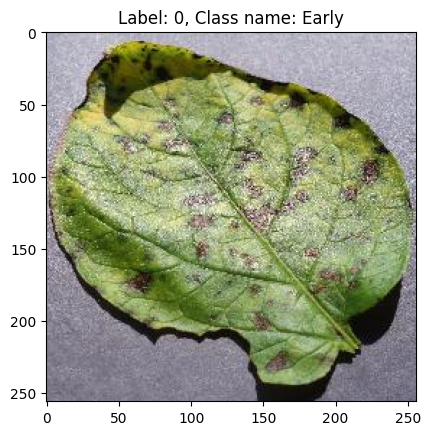

In [26]:
#Visualizing data
#Get 1st image
for image_batch, label_batch in dataset.take(1):
    image = Image.open(dataset.file_paths[1])
    plt.imshow(image)
    plt.title(f"Label: {label_batch[1].numpy()}, Class name: {dataset.class_names[label_batch[1].numpy()]}")
    plt.show()

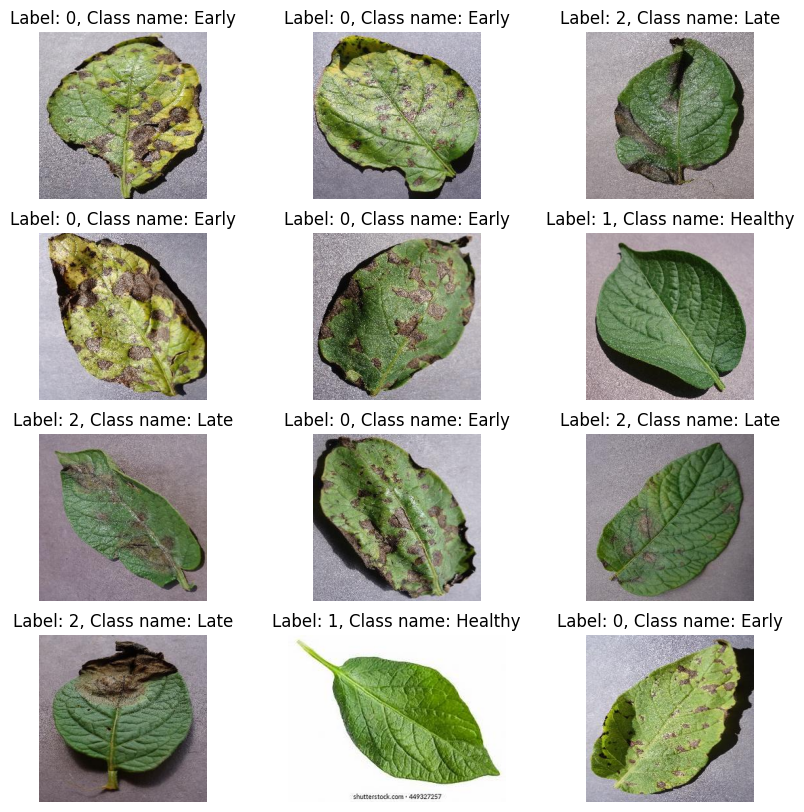

In [27]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(4,3,i+1)
        plt.imshow(Image.open(dataset.file_paths[i]))
        plt.title(f"Label: {label_batch[i].numpy()}, Class name: {dataset.class_names[label_batch[i].numpy()]}")
        plt.axis("off")

In [10]:
#Train split data
#80%=training
#20%=10% validation+ 10% testing

In [28]:
len(dataset)

75

In [98]:
#calculate 80% of training data
train_size=0.8
len(dataset)*train_size

60.0

In [99]:
#Get it into training dataset
train_ds=dataset.take(60)
len(train_ds)

60

In [100]:
#calculate 20% of remaining data
test_ds=dataset.skip(60)
len(test_ds)

15

In [101]:
#calculate 10% of validation data
val_size=0.1
len(dataset)*val_size

7.5

In [102]:
#Get it into validation dataset
val_ds=test_ds.take(7)
len(val_ds)

7

In [103]:
#Get it into testing dataset
test_ds=test_ds.skip(7)
len(test_ds)

8

In [29]:
#Train split data with the help of function
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [30]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [31]:
len(train_ds)

60

In [32]:
len(val_ds)

7

In [33]:
len(test_ds)

8

In [34]:
#Optimizing the performance 
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [38]:
#preprocessing taking care of scaling and sizing
resize_and_rescale=tf.keras.Sequential ([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1.0/255)
    ])


In [39]:
#Augmentation
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal and vertical"),
    layers.RandomRotation(0.2),
])


In [44]:
#building model for CNN
#Defining architecture
input_shape=(BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)
n_classes=3
model=Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)


In [53]:
#Printing the summary of model
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (32, 127, 127, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (32, 62, 62, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (32, 30, 30, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (32, 14, 14, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (32, 6, 6, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (32, 2, 2, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,44

 Total params: 185,155 (723.26 KB)

 Trainable params: 184,451 (720.51 KB)

 Non-trainable params: 704 (2.75 KB)

In [54]:
#Compiling the architecture
model.compile (
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)


In [55]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


In [56]:
#Train network
history =model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.3989 - loss: 1.1952 - val_accuracy: 0.3973 - val_loss: 1.0345
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4393 - loss: 1.0769 - val_accuracy: 0.3973 - val_loss: 1.0342
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.4712 - loss: 1.0271 - val_accuracy: 0.3973 - val_loss: 1.1073
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4636 - loss: 1.0465 - val_accuracy: 0.4286 - val_loss: 1.0539
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.4504 - loss: 1.0173 - val_accuracy: 0.4062 - val_loss: 1.0258
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4801 - loss: 1.0014 - val_accuracy: 0.4062 - val_loss: 1.0702
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4851 - loss: 1.0031 - val_accuracy: 0.3884 - val_loss: 1.0712
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4692 - loss: 0.9939 - val_accuracy: 0.3839 - val_loss

In [28]:
#testing by test data
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 422ms/step - accuracy: 0.4472 - loss: 1.0831


In [29]:
#displaying loss and accuracy for test
scores

[1.0336287021636963, 0.47265625]

In [30]:
#callback history access
history

NameError: name 'history' is not defined

In [31]:
history.params

NameError: name 'history' is not defined

In [29]:
#gets all the keys of history
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [30]:
#array of accuracy in history
history.history['accuracy']

[0.40514975786209106,
 0.42511823773384094,
 0.44823962450027466,
 0.4366789162158966,
 0.4566473960876465,
 0.4661061465740204,
 0.4661061465740204,
 0.488176554441452,
 0.46452969312667847,
 0.48554912209510803,
 0.5049921274185181,
 0.5028901696205139,
 0.5139253735542297,
 0.5097215175628662,
 0.5375722646713257,
 0.5239096283912659,
 0.5533368587493896,
 0.5585917234420776,
 0.558066189289093,
 0.573830783367157,
 0.5591171979904175,
 0.5822385549545288,
 0.5964266657829285,
 0.5948502421379089,
 0.5953757166862488,
 0.5916973352432251,
 0.5937992930412292,
 0.6174461245536804,
 0.6221755146980286,
 0.6237519979476929,
 0.6347872018814087,
 0.6542301774024963,
 0.6726222038269043,
 0.6563321352005005,
 0.6773515343666077,
 0.68418288230896,
 0.6668418049812317,
 0.6857593059539795,
 0.68418288230896,
 0.6831318736076355,
 0.7172884941101074,
 0.7004729509353638,
 0.7351550459861755,
 0.7493431568145752,
 0.7267472147941589,
 0.7404098510742188,
 0.747241199016571,
 0.7498686313629

In [ ]:
#plotting

In [32]:
#get arrays stored in different variables
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

NameError: name 'history' is not defined

NameError: name 'acc' is not defined

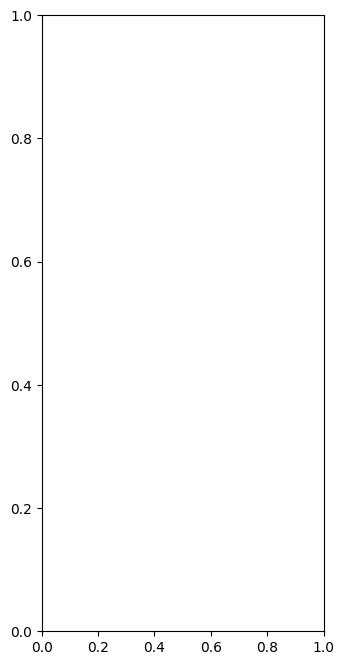

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & validation Accuracy')



plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training & validation Loss')
plt.show

First Image to predict
actual label: Late
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction label Early


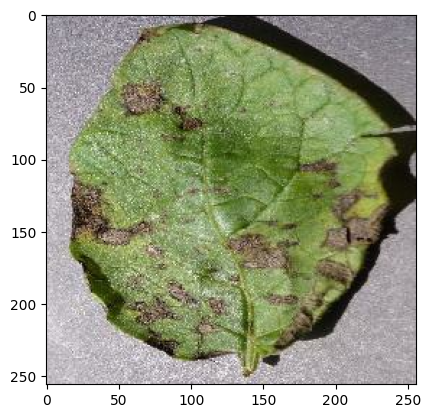

In [34]:
#Making prediction
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_img=image_batch[0].numpy().astype("uint8")
    first_label=label_batch[0].numpy()
    print("First Image to predict")
    plt.imshow(first_img)
    print ("actual label:",class_names[first_label])
    batch_prediction=model.predict(image_batch)
    print("Prediction label",class_names[np.argmax(batch_prediction[0])])
